Initial attempt at data processing for LDA
==
Loads a DESI image mzML file and processes it into binned bin x pixel numpy array

In [122]:
import numpy as np
import pylab as plt
import pymzml
%matplotlib inline

In [123]:
filename = '/Users/simon/Dropbox/MS_Ink_Data/Alphabet/abcdefgh_1.mzML'
run = pymzml.run.Reader(filename, MS1_Precision=5e-6)
nScans = run.getSpectrumCount()
print "Loaded {} scans".format(nScans)

Loaded 6327 scans


Define the mass bins (features) to use

In [124]:
minmz = 100
maxmz = 500
bins = np.arange(100,500,1)
binned_data = np.empty((len(bins),nScans),np.float)


In [125]:
sp = 0
for spectrum in run:
    for m,i in spectrum.peaks:
        mass_bin = int(np.floor(m))
        if mass_bin >= minmz and mass_bin < maxmz:
            binned_data[mass_bin-minmz][sp] += i
    sp += 1

In [138]:
def get_matrix(binned_data,nBins,nScans):
    n_rows = 8
    drop_perc = 1.25/(1.25+62)
    scans_per_line = nScans/n_rows
    nNonDrop = int(scans_per_line*(1-drop_perc))
    image_array = np.zeros((n_rows,nNonDrop,nBins),np.float)
    for index in range(nBins):
        pos = 0
        fwd = True
        for row in range(n_rows):
            if fwd:
                image_array[row,:,index] = binned_data[index,pos:pos+nNonDrop]
                pos += scans_per_line
                fwd = False
            else:
                temp_line = binned_data[index,pos:pos+nNonDrop]
                image_array[row,:,index] = temp_line[::-1]
                pos += scans_per_line
                fwd = True
    return image_array

Function to display an image for a particular bin index

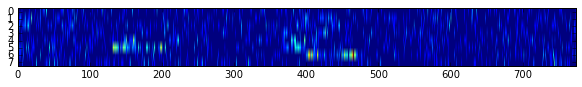

In [141]:
image_array = get_matrix(binned_data,len(bins),nScans)
plt.figure(figsize=(10,10))
plt.imshow(image_array[:,:,277],aspect=10)

In [176]:
class Word(object):
    def __init__(self,mid):
        self.mid = mid
    
    def __str__(self):
        return str(self.mid)
    def __repr__(self):
        return str(self.mid)

456820.50061
(8, 101, 400)


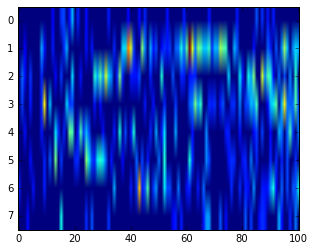

In [268]:
max_intensity = image_array.max()
print max_intensity
norm_max = 200
sub_image = image_array[:,360:461,:]
plt.imshow(sub_image[:,:,226],aspect=10)

words = []
for bin in range(len(bins)):
    words.append(bin)

print sub_image.shape

docs = {}

for row in range(8):
    for col in range(100):
        coord = (row,col)
        newdoc = {}
        for bin in range(len(bins)):
            intensity = int(norm_max*1.0*sub_image[row,col,bin]/max_intensity)
            if intensity > 0:
                newdoc[words[bin]] = []
                for i in range(intensity):
                    newdoc[words[bin]].append(0)
        docs[coord] = newdoc
            


In [269]:
K = 20 # Number of topics
# Initialise
for coord in docs:
    doc = docs[coord]
    for word in doc:
        membs = doc[word]
        for i,m in enumerate(membs):
            membs[i] = np.random.randint(K)

In [270]:
print docs[(6,42)]

{259: [18, 3, 12, 19, 14, 10, 18, 7], 260: [13], 138: [2], 139: [10], 275: [2, 12, 7, 5, 11, 11, 19, 10, 7, 19, 16, 17, 12, 15, 15, 18, 11, 14, 3, 11], 276: [16, 17, 18], 277: [18], 155: [12], 60: [9], 329: [13], 204: [0], 80: [16], 209: [12], 215: [7, 1], 90: [15], 225: [11, 18, 11, 0], 99: [19], 100: [4], 357: [18], 106: [16], 237: [2], 253: [1], 254: [10, 1, 2, 12, 13, 15, 7, 7, 10, 15, 1, 11, 12, 6], 255: [9, 10]}


In [271]:
doc_topic_counts = {}
for coord in docs:
    doc_topic_counts[coord] = np.zeros((K),np.int)
    doc = docs[coord]
    for word in doc:
        membs = doc[word]
        for m in membs:
            doc_topic_counts[coord][m] += 1

In [272]:
global_topic_counts = np.zeros((K),np.int)
for coord in doc_topic_counts:
    global_topic_counts += doc_topic_counts[coord]

In [273]:
alpha = 1.0
beta = 1.0

In [274]:
W = len(bins)
topic_word_counts = {}
topic_word_counts = np.zeros((K,W),np.int)

for coord in docs:
    doc = docs[coord]
    for word in doc:
        membs = doc[word]
        for m in membs:
            topic_word_counts[m][word] += 1

In [275]:
nSamples = 100
for sample in range(nSamples):
    print "Sample {}".format(sample)
    for coord in docs:
        doc = docs[coord]
        for word in doc:
            membs = doc[word]
            for i,m in enumerate(membs):
                topic_word_counts[m][word] -= 1
                doc_topic_counts[coord][m] -= 1
                global_topic_counts[m] -= 1
                
                pwordintopic = (topic_word_counts[:,word] + beta)/(topic_word_counts+beta).sum(axis=1)
                
                ptopicindoc = doc_topic_counts[coord] + alpha
                topicprobs = pwordintopic*ptopicindoc
                topicprobs /= topicprobs.sum()
                
                new_topic = np.random.choice(K,p=topicprobs)
                membs[i] = new_topic
                
                topic_word_counts[new_topic][word] += 1
                doc_topic_counts[coord][new_topic] += 1
                global_topic_counts[new_topic] += 1
                
                
                

Sample 0
Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18
Sample 19
Sample 20
Sample 21
Sample 22
Sample 23
Sample 24
Sample 25
Sample 26
Sample 27
Sample 28
Sample 29
Sample 30
Sample 31
Sample 32
Sample 33
Sample 34
Sample 35
Sample 36
Sample 37
Sample 38
Sample 39
Sample 40
Sample 41
Sample 42
Sample 43
Sample 44
Sample 45
Sample 46
Sample 47
Sample 48
Sample 49
Sample 50
Sample 51
Sample 52
Sample 53
Sample 54
Sample 55
Sample 56
Sample 57
Sample 58
Sample 59
Sample 60
Sample 61
Sample 62
Sample 63
Sample 64
Sample 65
Sample 66
Sample 67
Sample 68
Sample 69
Sample 70
Sample 71
Sample 72
Sample 73
Sample 74
Sample 75
Sample 76
Sample 77
Sample 78
Sample 79
Sample 80
Sample 81
Sample 82
Sample 83
Sample 84
Sample 85
Sample 86
Sample 87
Sample 88
Sample 89
Sample 90
Sample 91
Sample 92
Sample 93
Sample 94
Sample 95
Sample 96
Sample 97
Sample 98
Sample 99


[(275, 2112), (225, 589), (209, 228), (276, 227), (329, 122), (155, 101), (253, 69), (357, 58), (139, 38), (277, 37), (226, 27), (119, 14), (204, 12), (254, 11), (259, 11), (99, 10), (255, 9), (103, 8), (237, 8), (187, 7), (106, 5), (313, 5), (58, 4), (195, 4), (211, 4), (260, 4), (70, 3), (83, 3), (53, 2), (66, 2), (87, 2), (100, 2), (114, 2), (131, 2), (150, 2), (251, 2), (299, 2), (319, 2), (358, 2), (52, 1), (60, 1), (67, 1), (68, 1), (75, 1), (78, 1), (82, 1), (88, 1), (90, 1), (91, 1), (101, 1), (104, 1), (110, 1), (113, 1), (123, 1), (125, 1), (138, 1), (140, 1), (167, 1), (180, 1), (190, 1), (213, 1), (240, 1), (258, 1), (283, 1), (325, 1), (341, 1), (349, 1), (356, 1), (374, 1), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0)

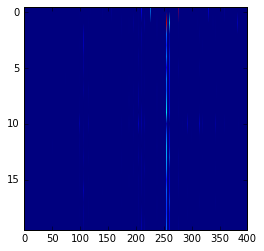

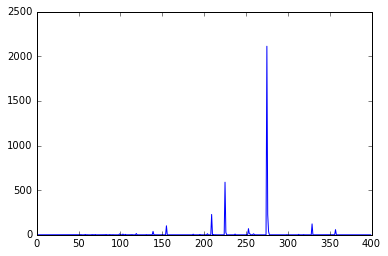

In [286]:
plt.imshow(topic_word_counts,aspect=20)
plt.figure()
plt.plot(topic_word_counts[0,:])
words = np.nonzero(topic_word_counts[0,:]>0)[0]

wc = []
for w in range(W):
    wc.append((w,topic_word_counts[0,w]))

wc = sorted(wc,key = lambda x: x[1],reverse=True)
print wc
print words

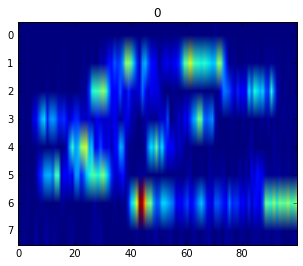

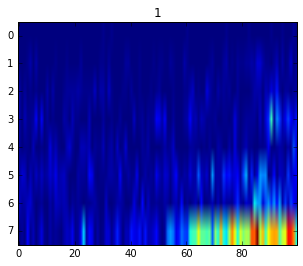

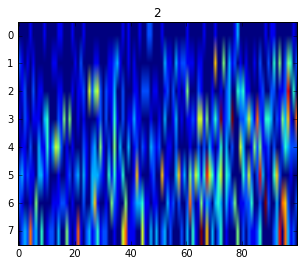

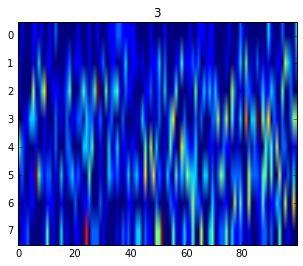

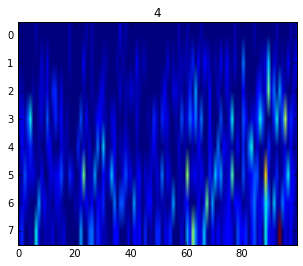

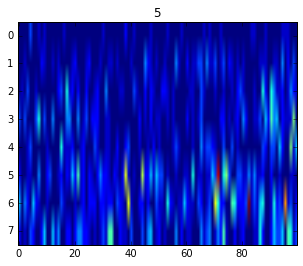

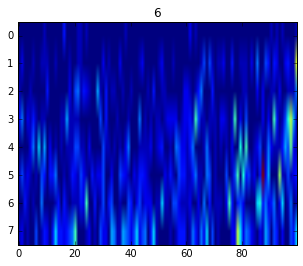

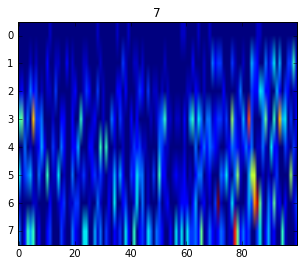

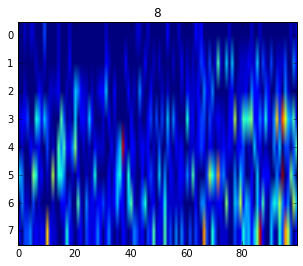

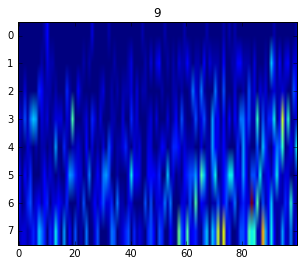

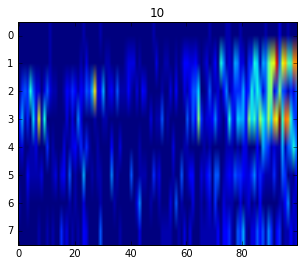

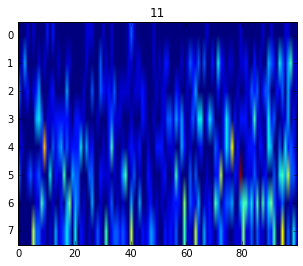

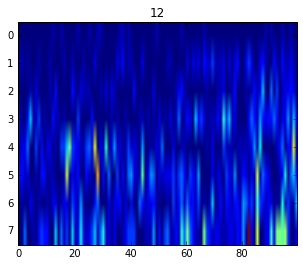

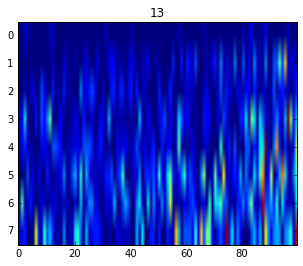

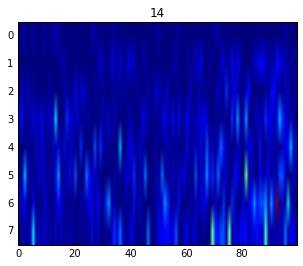

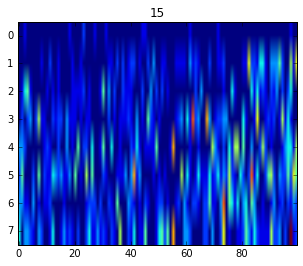

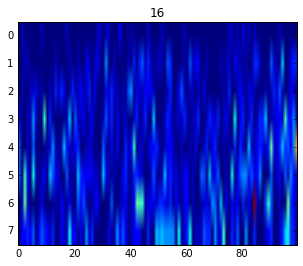

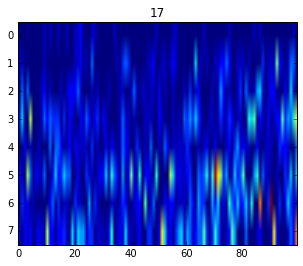

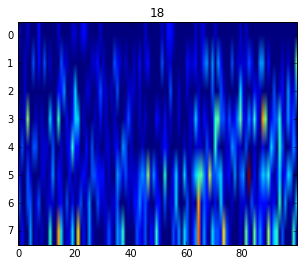

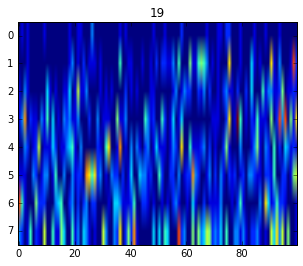

In [277]:
for topic in range(K):
    top_img = np.zeros((8,100),np.int)
    for coord in doc_topic_counts:
        topic_counts = doc_topic_counts[coord]
        top_img[coord[0],coord[1]] = topic_counts[topic]
    plt.figure()
    plt.imshow(top_img,aspect=10)
    plt.title('{}'.format(topic))

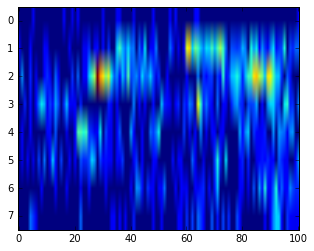

In [294]:
plt.imshow(sub_image[:,:,357],aspect=10)